# Compare the performance of the NN and the GP system model

In this Jupyter notebook we compare the performance of the NN and GP system model for the kite through open-loop predictions. In other words: We repeatedly evaluate both models for a given initial state and some sequence of inputs. 
We know the true state trajectory that should emerge and compare the NN and GP predictions to this trajectory.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('../../../do-mpc/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from nn_tools import NNPredictModel
from gp_tools import GPPredictModel

import gp_tools
import nn_tools

from casadi import *

In [2]:
%matplotlib notebook

In [3]:
mpl.rcParams.update({
    'lines.linewidth':2,
    'font.size': 16,
    'figure.figsize': (9, 6),
    'axes.grid': False,
    'lines.markersize': 10,
    'text.usetex': True,
    'axes.unicode_minus': False,
    'ps.fonttype': 42,
    'pdf.fonttype': 42
})

## Load prepared  validation data

See Jupyter Notebook ``train_test_val_data_prep.ipynb`` for details.

In [5]:
load_name = 'S01_Prep_01'
load_path = './data_prep/'

data = do_mpc.tools.load_pickle(load_path + load_name + '.pkl')

# Test sequences:
test_res = data['test_res']

# Neural Network

In [6]:
export_name = 'S01_NN_M01'
export_path = './nn_models/{}/'

nn_model_aux = do_mpc.tools.load_pickle(export_path.format(export_name) + export_name + '_aux.pkl')
nn_model = keras.models.load_model(export_path.format(export_name))

2021-12-01 14:40:31.291490: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-01 14:40:31.291678: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
nn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 6)]               0         
_________________________________________________________________
hidden_1 (Dense)             (None, 20)                140       
_________________________________________________________________
hidden_2 (Dense)             (None, 20)                420       
_________________________________________________________________
output (Dense)               (None, 5)                 105       
Total params: 665
Trainable params: 665
Non-trainable params: 0
_________________________________________________________________


Create the activation model with the trained weights from the loaded model.

In [8]:
nn_in = nn_model.get_layer('input')
nn_ll = nn_model.get_layer('hidden_2')

activation_model = keras.backend.function(nn_in.input, nn_ll.output)

# Gaussian Process

In [9]:
export_name = 'S01_GP_M01_200' # 200 samples
# or:
#export_name = 'S01_GP_M02_100' # 100 samples
export_path = './gp_models/{}/'

gp_model = do_mpc.tools.load_pickle(export_path.format(export_name) + export_name + '_gp.pkl')

gpr = GaussianProcessRegressor(kernel=RBF(length_scale=gp_model['l']),alpha=gp_model['alpha'], optimizer=None).fit(
    gp_model['X_train'], gp_model['Y_train'])

# Comparison

Compute open-loop predictions for all test cases with GP and NN model.

In [10]:
nn_traj = {'x': [], 'v': [], 'aux':[]}
gp_traj = {'x': [], 'v': [], 'aux':[]}

for i, res_i in enumerate(test_res):
    x0 = (res_i['states'][0]).reshape(-1,1)
    pm_nn = NNPredictModel(nn_model, activation_model, nn_model_aux['a_train'], 
                    nn_model_aux['in_scaler'], nn_model_aux['out_scaler'], x0)
    pm_gp = GPPredictModel(gpr, gp_model['in_scaler'], gp_model['out_scaler'], x0)

    for k in range(res_i['states'].shape[0]):
        u0 = res_i['input'][k]
        p = res_i['wind'][k]
        pm_nn.make_step(u0,p)
        pm_gp.make_step(u0,p)
        
    nn_traj['v'].append(pm_nn.v)
    gp_traj['v'].append(pm_gp.v)
    
    nn_traj['x'].append(pm_nn.x)
    gp_traj['x'].append(pm_gp.x)
    
    nn_traj['aux'].append(pm_nn.aux)
    gp_traj['aux'].append(pm_gp.aux)

Compute performance metrics for all test cases.

In [11]:
nn_err = {'x': [], 'aux':[]}
gp_err = {'x': [], 'aux':[]}

for i, res_i in enumerate(test_res):
    res_i_aux = np.concatenate((res_i['T_F'], res_i['height']),axis=1)
    
    nn_x_err_i = np.sum(np.abs(res_i['states']-nn_traj['x'][i][:-1,:]),axis=0)
    nn_aux_err_i = np.sum(np.abs(res_i_aux-nn_traj['aux'][i]),axis=0)
    
    gp_x_err_i = np.sum(np.abs(res_i['states']-gp_traj['x'][i][:-1,:]),axis=0)
    gp_aux_err_i = np.sum(np.abs(res_i_aux-gp_traj['aux'][i]),axis=0)
    
    nn_err['x'].append(nn_x_err_i)
    nn_err['aux'].append(nn_aux_err_i)
    
    gp_err['x'].append(gp_x_err_i)
    gp_err['aux'].append(gp_aux_err_i)

In [12]:
mean_sum_err_nn = np.mean(nn_err['aux'],axis=0)
mean_sum_err_gp = np.mean(gp_err['aux'],axis=0)

improvement_nn_vs_gp = (mean_sum_err_nn-mean_sum_err_gp)/mean_sum_err_gp*100

print(f'NN reduced error for T_f by {improvement_nn_vs_gp[0]:.2f}% and h by {improvement_nn_vs_gp[1]:.2f}%.')

NN reduced error for T_f by -2.35% and h by -20.83%.


### Graphical evaluation

Plot for all 20 sequences the GP and NN prediction vs. the true trajectory

<IPython.core.display.Javascript object>


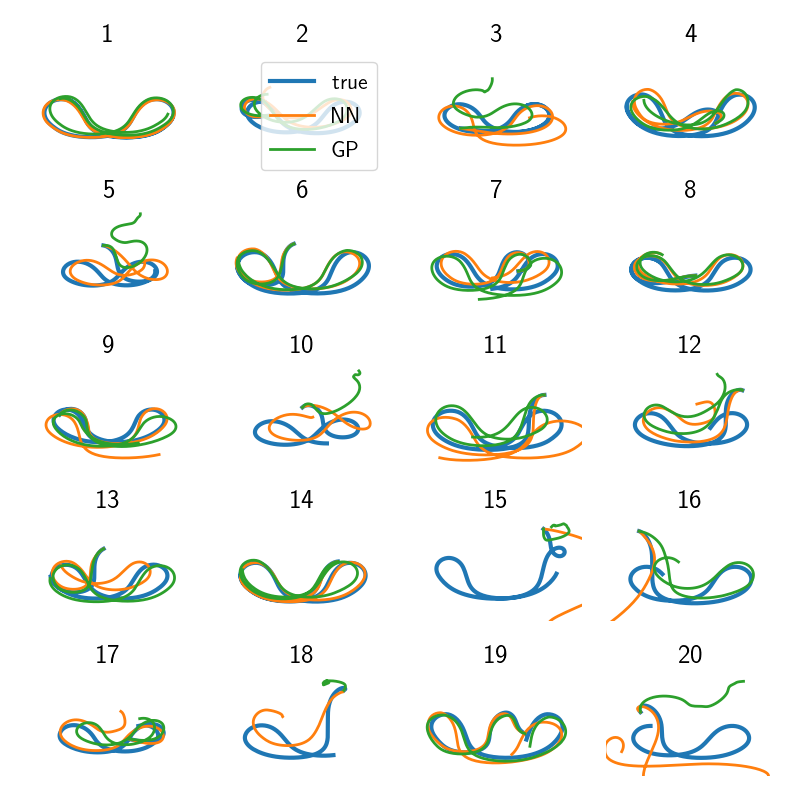

(0.0, 1.4)

In [13]:
n_eval = 20

n_row = int(np.ceil(np.sqrt(n_eval)))
n_col = int(np.ceil(n_eval/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(8,8))
for i, res_i in enumerate(test_res[:n_eval]):
    ax[i//n_col, np.mod(i,n_col)].plot(res_i['states'][:,1],res_i['states'][:,0],linewidth=3, label='true')
    ax[i//n_col, np.mod(i,n_col)].plot(nn_traj['x'][i][:,1], nn_traj['x'][i][:,0], label='NN')
    ax[i//n_col, np.mod(i,n_col)].plot(gp_traj['x'][i][:,1], gp_traj['x'][i][:,0], label='GP')
    ax[i//n_col, np.mod(i,n_col)].set_title(i+1)
    
for i in range(ax.size):
    ax[i//n_col, np.mod(i,n_col)].axis('off')

fig.tight_layout()

ax[0,1].legend()

ax[0,0].set_xlim(-1.5,1.5)
ax[0,0].set_ylim(0,1.4)

Plot shown in paper. Highlight also those points that violate the trust region constraint:

<IPython.core.display.Javascript object>


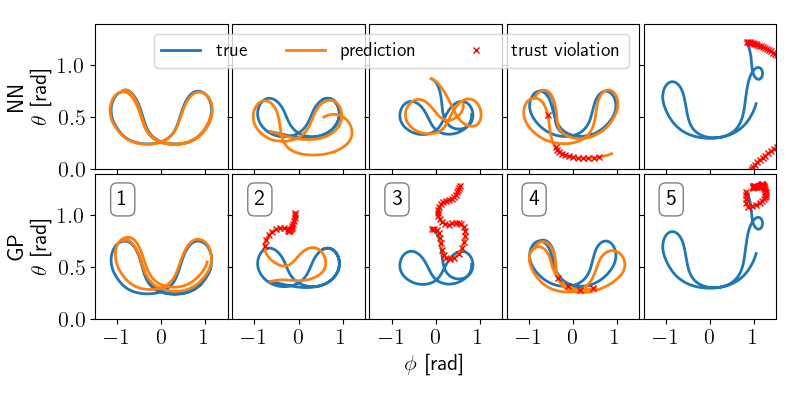

(0.0, 1.4)

In [14]:
n_eval = 6

cases = [0,2,4,8,14]
n_eval = len(cases)

fig, ax = plt.subplots(2,n_eval,sharex=True,sharey=True, figsize=(8,4))

trust_threshold_nn = 0.02
trust_threshold_gp = 0.2

box_props = dict(boxstyle='round', edgecolor='black', facecolor='white', alpha=0.5)

for k,i in enumerate(cases):
    ax[0,k].plot(test_res[i]['states'][:,1],test_res[i]['states'][:,0], label='true')
    ax[0,k].plot(nn_traj['x'][i][:,1], nn_traj['x'][i][:,0], label='prediction')
    
    viol_ind = (nn_traj['v'][i]>= trust_threshold_nn).flatten()
    ax[0,k].plot(nn_traj['x'][i][1:,:][viol_ind,1], nn_traj['x'][i][1:,:][viol_ind,0],
                                      'x', color='red', markersize=5, label='trust violation')
    
    
for k,i in enumerate(cases):
    ax[1,k].text(-1,1.1,k+1, bbox=box_props)
    
    ax[1,k].plot(test_res[i]['states'][:,1],test_res[i]['states'][:,0], label='true')
    ax[1,k].plot(gp_traj['x'][i][:,1], gp_traj['x'][i][:,0], label='prediction')
    
    viol_ind = (gp_traj['v'][i]>= trust_threshold_gp).flatten()
    ax[1,k].plot(gp_traj['x'][i][1:,:][viol_ind,1], gp_traj['x'][i][1:,:][viol_ind,0],
                                      'x', color='red',markersize=5,markevery=5, label='trust violation')

ax[0,0].set_ylabel('NN\n' + r'$\theta$ [rad]') 
ax[1,0].set_ylabel('GP\n' + r'$\theta$ [rad]')
ax[1,n_eval//2].set_xlabel(r'$\phi$ [rad]')

fig.tight_layout(h_pad=0, w_pad=0)
ax[0,3].legend(ncol=3,loc=1, fontsize=14)

ax[0,0].set_xlim(-1.5,1.5)
ax[0,0].set_ylim(0,1.4)

#fig.savefig('./figures/Kite_GP_NN_open_loop_prediction.pdf',format='pdf', pad_inches=0)

## Evaluate execution speed

### Gaussian Processes

Obtain implementation of GPs in CasADi formulation:

In [17]:
x_cas = SX.sym('x', 1,6)

gp_cas = gp_tools.GP(gp_tools.RBF(l=gp_model['l']))
gp_cas.fit(gp_model['X_train'], gp_model['Y_train'], Sigma=gp_model['alpha']*np.eye(gp_model['X_train'].shape[0]))

y_sym_gp, v_sym_gp = gp_cas.predict(x_cas)

f_gp =  Function('f_gp', [x_cas], [y_sym_gp, v_sym_gp])
df_gp = Function('f_nn', [x_cas], [jacobian(y_sym_gp, x_cas), jacobian(v_sym_gp, x_cas)])

faster code
faster code


In [18]:
gp_sklearn = GaussianProcessRegressor(RBF(length_scale=gp_model['l']), optimizer=None).fit(gp_model['X_train'], gp_model['Y_train'])

Compare GP results of own implementation with Sklearn
(validation that re-implementation is correct).

In [20]:
y_hat_gp_skl, v_hat_gp_skl = gp_sklearn.predict(np.zeros((1,6)), return_cov=True)
y_hat_gp_cas, v_hat_gp_cas = f_gp(np.zeros((1,6)))

print(f'Max. error between sklearn GP and own implementation: {np.max(np.abs((y_hat_gp_skl - y_hat_gp_cas)))}')

Max. error between sklearn GP and own implementation: 4.146404796623315e-06


Timing of GP own implementation vs. sklearn (notice that the numbers in our publication might vary slightly)

In [21]:
%%timeit
f_gp(np.zeros((1,6)))

285 µs ± 4.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [22]:
%%timeit
gp_sklearn.predict(np.zeros((1,6)), return_cov=True)

175 µs ± 8.62 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Timing of jacobian / gradient computation:

In [23]:
%%timeit
df_gp(np.zeros((1,6)))

1.05 ms ± 82.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Neural Networks

Also re-implemented in CasADi.

In [24]:
activations = nn_tools.keras2casadi(nn_model, x_cas.T)

y_sym_nn = activations[-1]
v_sym_nn = activations[-2]@nn_model_aux['C']@activations[-2].T

f_nn = Function('f_nn', [x_cas],[y_sym_nn, v_sym_nn])
df_nn = Function('f_nn', [x_cas], [jacobian(y_sym_nn, x_cas), jacobian(v_sym_nn, x_cas)])

In [25]:
%%timeit
f_nn(np.zeros((1,6)))

23.1 µs ± 608 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [26]:
%%timeit
df_nn(np.zeros((1,6)))

40 µs ± 1.94 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
